<br><font color='green'>
## ch.4 Libraries, Read data(1)

In [1]:
# basic 

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50, 'display.max_rows', 200)
from itertools import combinations

# plot

import seaborn as sns
import matplotlib.pylab as plt
from matplotlib import font_manager, rc

import platform
your_os = platform.system()
if your_os == 'Linux':
    rc('font', family='NanumGothic')
elif your_os == 'Windows':
    ttf = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=ttf).get_name()
    rc('font', family=font_name)
elif your_os == 'Darwin':
    rc('font', family='AppleGothic')
rc('axes', unicode_minus=False)


# models
import time
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, KFold

from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectPercentile
from scipy.stats.mstats import gmean
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import ShuffleSplit

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier
from sklearn import svm
from sklearn.ensemble import ExtraTreesClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from bayes_opt import BayesianOptimization
from sklearn.ensemble import VotingClassifier
from vecstack import StackingTransformer
from vecstack import stacking

%run import_modules.py  
%matplotlib inline

# For DNN modeling
import tensorflow as tf

# Tensorflow warning off
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
#  tf.logging.set_verbosity(tf.logging.ERROR) <- logging이 버전업그레이드에서 사용 X라함

# from tensorflow import set_random_seed 
# 위에 코드 안됨에 대한 답변: In Tensoflow2 there is no need to perform
# from tensorflow import set_random_seed
# in order to run
# set_random_seed(x)
# (as it was in older version)
# Only have to run
# import tensorflow
# tensorflow.random.set_seed(x)

tf.random.set_seed(2020)
import keras
from keras import backend as K
from keras.layers import * #Input, Dense
from keras.models import * #Model
from keras.optimizers import *
from keras.initializers import *
from keras.regularizers import *
from keras.utils.np_utils import *
from keras.utils.vis_utils import * #model_to_dot

Using TensorFlow backend.


### Read Data(1)

In [2]:
df_train = pd.read_csv('X_train.csv', encoding='cp949')
df_test = pd.read_csv('X_test.csv', encoding='cp949')
y_train = pd.read_csv('y_train.csv')
IDtest = df_test.cust_id.unique()

In [3]:
X_train = pd.read_csv('X_train_after_preprocessing.csv',encoding='cp949')
X_test = pd.read_csv('X_test_after_preprocessing.csv', encoding='cp949')
IDtest = df_test.cust_id.unique()
y_train = pd.read_csv('y_train.csv').gender

### 3. Feature Engineering

<font color="#CC3D3D">*Generate k-means clustering features*

In [4]:
from sklearn.cluster import KMeans

class KMeansFeaturizer:
    """Transforms numeric data into k-means cluster memberships.
    
    This transformer runs k-means on the input data and converts each data point
    into the id of the closest cluster. If a target variable is present, it is 
    scaled and included as input to k-means in order to derive clusters that
    obey the classification boundary as well as group similar points together.

    Parameters
    ----------
    k: integer, optional, default 100
        The number of clusters to group data into.

    target_scale: float, [0, infty], optional, default 5.0
        The scaling factor for the target variable. Set this to zero to ignore
        the target. For classification problems, larger `target_scale` values 
        will produce clusters that better respect the class boundary.

    random_state : integer or numpy.RandomState, optional
        This is passed to k-means as the generator used to initialize the 
        kmeans centers. If an integer is given, it fixes the seed. Defaults to 
        the global numpy random number generator.

    Attributes
    ----------
    cluster_centers_ : array, [k, n_features]
        Coordinates of cluster centers. n_features does count the target column.
    """

    def __init__(self, k=100, target_scale=5, random_state=None):
        self.k = k
        self.target_scale = target_scale
        self.random_state = random_state
        self.cluster_encoder = OneHotEncoder().fit(np.array(range(k)).reshape(-1,1))
        
    def fit(self, X, y=None):
        """Runs k-means on the input data and find centroids.

        If no target is given (`y` is None) then run vanilla k-means on input
        `X`. 

        If target `y` is given, then include the target (weighted by 
        `target_scale`) as an extra dimension for k-means clustering. In this 
        case, run k-means twice, first with the target, then an extra iteration
        without.

        After fitting, the attribute `cluster_centers_` are set to the k-means
        centroids in the input space represented by `X`.

        Parameters
        ----------
        X : array-like or sparse matrix, shape=(n_data_points, n_features)

        y : vector of length n_data_points, optional, default None
            If provided, will be weighted with `target_scale` and included in 
            k-means clustering as hint.
        """
        if y is None:
            # No target variable, just do plain k-means
            km_model = KMeans(n_clusters=self.k, n_init=20, random_state=self.random_state)
            km_model.fit(X)

            self.km_model_ = km_model
            self.cluster_centers_ = km_model.cluster_centers_
            return self

        # There is target information. Apply appropriate scaling and include
        # into input data to k-means            
        data_with_target = np.hstack((X, y[:,np.newaxis]*self.target_scale))

        # Build a pre-training k-means model on data and target
        km_model_pretrain = KMeans(n_clusters=self.k, n_init=20, random_state=self.random_state)
        km_model_pretrain.fit(data_with_target)

        # Run k-means a second time to get the clusters in the original space
        # without target info. Initialize using centroids found in pre-training.
        # Go through a single iteration of cluster assignment and centroid 
        # recomputation.
        km_model = KMeans(n_clusters=self.k, 
                          init=km_model_pretrain.cluster_centers_[:,:data_with_target.shape[1]-1], 
                          n_init=1, max_iter=1)
        km_model.fit(X)
        
        self.km_model = km_model
        self.cluster_centers_ = km_model.cluster_centers_
        return self
        
    def transform(self, X, y=None):
        """Outputs the closest cluster id for each input data point.

        Parameters
        ----------
        X : array-like or sparse matrix, shape=(n_data_points, n_features)

        y : vector of length n_data_points, optional, default None
            Target vector is ignored even if provided.

        Returns
        -------
        cluster_ids : array, shape[n_data_points,1]
        """
        clusters = self.km_model.predict(X)
        onehot = self.cluster_encoder.transform(clusters.reshape(-1,1)).toarray()
        max_col = onehot.shape[1]
        pca = PCA(n_components=max_col, random_state=0).fit(onehot)
        cumsum = np.cumsum(pca.explained_variance_ratio_)
        num_col = np.argmax(cumsum >= 0.99) + 1
        if num_col == 1: num_col = max_col
        pca = PCA(n_components = num_col, random_state=0).fit_transform(onehot)
        return pd.DataFrame(pca)
    
    def fit_transform(self, X, y=None):
        """Runs fit followed by transform.
        """
        self.fit(X, y)
        return self.transform(X, y)

In [5]:
# Perform k-means clustering
# 최적의 k와 target_scale 값을 찾아야함.
kmf_hint = KMeansFeaturizer(k=5, target_scale=5, random_state=0).fit(X_train, y_train)
#kmf_no_hint = KMeansFeaturizer(k=30, target_scale=0, random_state=0).fit(train_x, y_train)

# Generate k-means clustering features
training_cluster_features = kmf_hint.transform(X_train)
test_cluster_features = kmf_hint.transform(X_test)

# Augment existing features with the k-means clustering features
X_train = pd.concat([X_train, training_cluster_features], axis=1)
X_test = pd.concat([X_test, test_cluster_features], axis=1)
X_train.columns = range(1, X_train.shape[1]+1)
X_test.columns = range(1, X_test.shape[1]+1)

print(X_train.shape)

(3500, 147)


*Select Features*

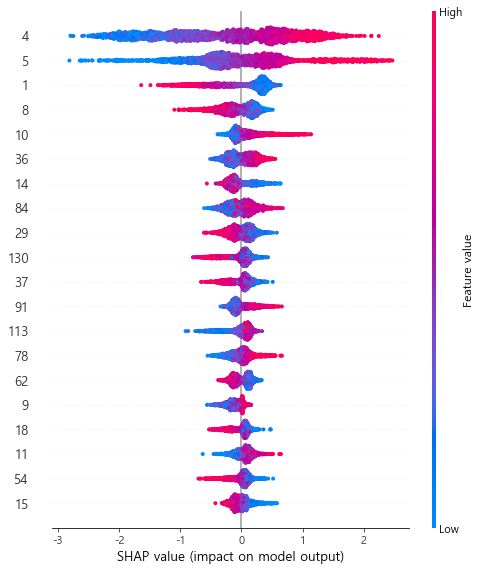

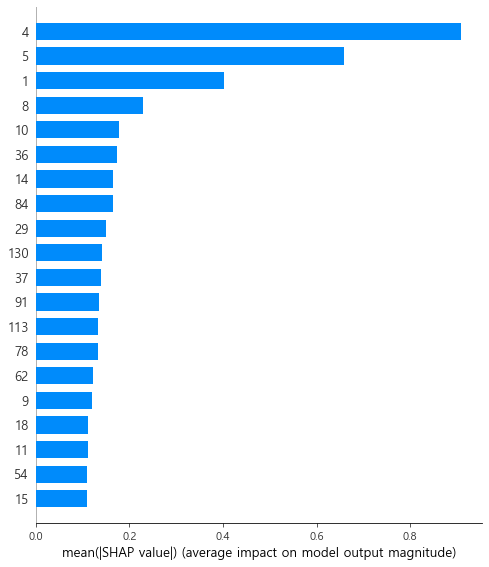

,column_name,shap_importance
3,4.0,0.908472
4,5.0,0.658867
0,1.0,0.402261
7,8.0,0.227955
9,10.0,0.177702
35,36.0,0.173296
13,14.0,0.164534
83,84.0,0.164437
28,29.0,0.148888
129,130.0,0.141244


In [6]:
# Method 2: Using SHAP values

import shap

# DF, based on which importance is checked
X_importance = X_test

# Explain model predictions using shap library:
model = XGBClassifier(random_state=0).fit(X_train, y_train)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_importance)

#model = LogisticRegression(random_state=0).fit(train_x, y_train)
#explainer = shap.LinearExplainer(model, train_x, feature_dependence="independent")
#shap_values = explainer.shap_values(X_importance)

# Plot summary_plot
shap.summary_plot(shap_values, X_importance)
# Plot summary_plot as barplot:
shap.summary_plot(shap_values, X_importance, plot_type='bar')

shap_sum = np.abs(shap_values).mean(axis=0)
importance_df = pd.DataFrame([X_importance.columns.tolist(), shap_sum.tolist()]).T
importance_df.columns = ['column_name', 'shap_importance']
importance_df = importance_df.sort_values('shap_importance', ascending=False)
importance_df

100%|██████████████████████████████████████████████████████████████████████████████████| 95/95 [00:08<00:00, 11.66it/s]


(40, 0.7580229291707091)


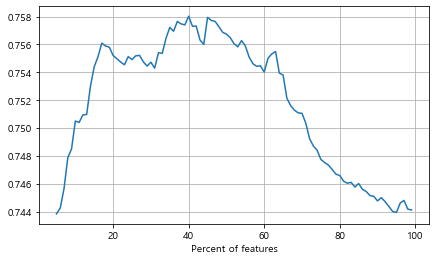

In [7]:
model = LogisticRegression(random_state=0)

cv_scores = []
for p in tqdm(range(5,100,1)):
    nf = int(importance_df.shape[0] * p * 0.01)
    features_selected = importance_df.iloc[:nf].column_name
    X_new = X_train[features_selected]
    cv_score = cross_val_score(model, X_new, y_train, scoring='roc_auc', cv=5).mean()
    cv_scores.append((p,cv_score))

# Print the best percentile
best_score = cv_scores[np.argmax([score for _, score in cv_scores])]
print(best_score)

# Plot the performance change with p
plt.figure(figsize=(7,4))
plt.plot([k for k, _ in cv_scores], [score for _, score in cv_scores])
plt.xlabel('Percent of features')
plt.grid()

In [8]:
# 과적합을 피하기 위해 최적의 p값 주변의 값을 선택하는게 더 나은 결과를 얻을 수 있다. 
nf = int(importance_df.shape[0] * best_score[0] * 0.01)
features_selected = importance_df.iloc[:nf].column_name
train_p = X_train[features_selected]
test_p = X_test[features_selected]

### Read Data

In [9]:
df_train = pd.read_csv('X_train.csv', encoding='cp949')
df_test = pd.read_csv('X_test.csv', encoding='cp949')
y_train = pd.read_csv('y_train.csv').gender
IDtest = df_test.cust_id.unique()

df_train.head()

,cust_id,tran_date,store_nm,goods_id,gds_grp_nm,gds_grp_mclas_nm,amount
0,0,2007-01-19 00:00:00,강남점,127105,기초 화장품,화장품,850000
1,0,2007-03-30 00:00:00,강남점,342220,니 트,시티웨어,480000
2,0,2007-03-30 00:00:00,강남점,127105,기초 화장품,화장품,3000000
3,0,2007-03-30 00:00:00,강남점,342205,니 트,시티웨어,840000
4,0,2007-03-30 00:00:00,강남점,342220,상품군미지정,기타,20000


### Transform Categorical Data using BOW

In [10]:
level = 'gds_grp_nm'

df_all = pd.concat([df_train, df_test])
train1 = pd.pivot_table(df_all, index='cust_id', columns=level, values='amount',
                         aggfunc=lambda x: np.where(len(x) >=1, 1, 0), fill_value=0). \
                         reset_index(). \
                         query('cust_id not in @IDtest'). \
                         drop(columns=['cust_id']).values
test1 = pd.pivot_table(df_all, index='cust_id', columns=level, values='amount',
                         aggfunc=lambda x: np.where(len(x) >=1, 1, 0), fill_value=0). \
                         reset_index(). \
                         query('cust_id in @IDtest'). \
                         drop(columns=['cust_id']).values

level = 'gds_grp_mclas_nm'

df_all = pd.concat([df_train, df_test])
train2 = pd.pivot_table(df_all, index='cust_id', columns=level, values='amount',
                         aggfunc=lambda x: np.where(len(x) >=1, 1, 0), fill_value=0). \
                         reset_index(). \
                         query('cust_id not in @IDtest'). \
                         drop(columns=['cust_id']).values
test2 = pd.pivot_table(df_all, index='cust_id', columns=level, values='amount',
                         aggfunc=lambda x: np.where(len(x) >=1, 1, 0), fill_value=0). \
                         reset_index(). \
                         query('cust_id in @IDtest'). \
                         drop(columns=['cust_id']).values

level = 'goods_id'

df_all = pd.concat([df_train, df_test])
train3 = pd.pivot_table(df_all, index='cust_id', columns=level, values='amount',
                         aggfunc=lambda x: np.where(len(x) >=1, 1, 0), fill_value=0). \
                         reset_index(). \
                         query('cust_id not in @IDtest'). \
                         drop(columns=['cust_id']).values
test3 = pd.pivot_table(df_all, index='cust_id', columns=level, values='amount',
                         aggfunc=lambda x: np.where(len(x) >=1, 1, 0), fill_value=0). \
                         reset_index(). \
                         query('cust_id in @IDtest'). \
                         drop(columns=['cust_id']).values

train = np.hstack([train1, train2, train3])
test = np.hstack([test1, test2, test3])

train.shape, test.shape

((3500, 4179), (2482, 4179))

In [11]:
train_ae = pd.DataFrame(train)
test_ae = pd.DataFrame(test)

In [12]:
train = pd.concat([train_p, train_ae], axis=1)
test = pd.concat([test_p, test_ae], axis=1)
train.shape, test.shape

((3500, 4237), (2482, 4237))

In [13]:
train

,4,5,1,8,10,36,14,84,29,130,37,91,113,78,62,9,18,11,54,15,103,101,74,32,110,...,4154,4155,4156,4157,4158,4159,4160,4161,4162,4163,4164,4165,4166,4167,4168,4169,4170,4171,4172,4173,4174,4175,4176,4177,4178
0,-0.765028,0.398815,1.167911,-0.988748,0.048043,0.106446,0.983594,-0.257070,0.934519,0.103882,-0.425401,0.082043,-0.097055,0.070290,-0.078611,1.275565,0.577789,0.313155,-0.125490,0.189278,-0.074756,-0.062868,0.312614,0.129190,0.168137,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.535205,-0.000806,-1.276551,-0.475146,-0.620795,-0.080641,-0.284698,-0.119245,-0.400371,0.056208,0.025701,0.130235,-0.010749,-0.006182,-0.385890,0.591800,-0.309674,-0.214921,-0.372054,-0.094409,-0.195274,-0.001419,0.271573,-0.493367,0.171110,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0.166401,0.294104,-1.558780,-0.340443,-0.124565,0.273298,-0.258650,-0.102554,-0.588816,-0.020423,-0.868179,-0.042487,0.029832,0.176513,-0.011309,0.803131,-0.572827,-0.367997,0.127042,0.218843,-0.146646,0.077921,-0.021899,0.564232,-0.127750,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0.513225,-0.239022,0.296805,0.442857,-0.177497,-0.173959,-0.108993,-0.005426,0.929201,0.022621,0.175132,0.385507,-0.053065,0.488316,-0.471285,1.139694,-0.142498,0.169107,0.535393,0.171279,0.099620,-0.180053,0.018420,0.130350,0.007552,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,-0.375504,-0.057823,-1.122380,-0.750766,-0.486642,0.242855,-0.240343,0.539340,-0.073307,-0.008030,0.017726,-0.232954,-0.070152,-0.378102,-0.367616,0.833933,0.060690,-0.213687,0.460166,-0.373559,0.129799,0.003699,0.057495,-0.113441,0.085377,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,0.568243,0.300601,-1.401014,0.248556,0.049428,0.416065,0.233565,0.090291,0.188253,0.024089,0.176339,-0.046661,0.015925,-0.174344,-0.024198,0.272241,-0.266560,0.467254,-0.195193,0.411395,0.073747,0.122364,-0.195173,-0.421599,0.244998,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3496,-0.254926,0.113134,-0.652176,-0.490601,-0.284070,-0.025559,-0.425187,-0.100497,0.423980,-0.014676,-0.129494,0.356370,0.041141,-0.414930,0.256546,-0.042355,-0.143208,0.734024,-0.399902,-0.178942,-0.179934,0.088237,0.328097,0.289349,0.120778,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3497,0.200635,-0.155372,-1.915213,0.402610,0.084461,-0.164915,-0.227817,0.006407,0.282796,-0.021174,0.031767,-0.010264,-0.033874,0.075579,0.127318,-0.465502,-0.041681,-0.377889,-0.078878,0.468600,-0.198167,0.147685,-0.041907,0.514161,-0.157228,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3498,-0.369539,-0.443443,-1.567451,-0.094451,0.267294,-0.194108,0.413782,-0.194929,0.557872,0.008885,0.057937,-0.109383,-0.039261,-0.046613,-0.201227,-0.093159,0.363679,-0.537589,-0.271504,-0.358584,0.267758,-0.020535,0.070030,0.139543,0.025586,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [14]:
test

,4,5,1,8,10,36,14,84,29,130,37,91,113,78,62,9,18,11,54,15,103,101,74,32,110,...,4154,4155,4156,4157,4158,4159,4160,4161,4162,4163,4164,4165,4166,4167,4168,4169,4170,4171,4172,4173,4174,4175,4176,4177,4178
0,0.968627,0.598306,0.293715,-0.178054,0.488430,-0.094249,-0.841070,-0.045251,0.218675,-0.004063,0.222124,-0.033501,-0.015288,0.322016,0.301451,0.319015,0.031511,0.673829,0.274979,-0.741223,0.084762,-0.010697,0.117668,-0.527836,-0.319057,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,-0.035261,0.162427,1.090224,0.633008,-1.142998,0.093573,0.380850,0.052878,-0.032008,-0.113580,-0.308013,0.082590,0.154702,0.278147,-0.373593,-0.197373,0.451738,0.056500,-0.064829,0.542133,0.182454,0.151373,-0.142251,-0.661592,-0.282667,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,-0.329604,0.068664,4.071454,0.299744,0.697304,-0.480486,-0.353687,-0.338620,-0.011634,0.041713,0.395189,0.253637,-0.237743,0.547593,0.121549,-0.165226,-0.343820,-0.400255,-0.024104,0.156051,0.140329,-0.191839,0.081423,0.575392,0.019656,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
3,-0.182537,-0.802113,-1.001377,-0.447091,0.124623,0.039670,0.460059,-0.248952,0.613709,-0.085126,0.040169,0.220614,0.017339,0.193289,0.177878,0.054622,-0.001570,-0.649769,0.113632,0.079824,-0.106610,-0.095795,0.625793,0.206799,-0.108445,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0.118488,0.168404,-1.151054,0.081152,0.059903,-0.056746,-0.341015,0.071800,0.359704,-0.065156,0.211823,0.259841,-0.058772,0.076933,0.477785,-0.045422,0.406106,-0.370495,0.484898,0.750299,-0.185089,0.113403,0.106134,0.055268,-0.118834,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2477,0.318876,0.107321,-0.235021,-0.374501,-0.101464,-0.036994,-0.126307,-0.011423,-0.175494,-0.015112,0.102383,-0.129922,0.013042,0.063252,0.476591,-0.803366,-0.067756,0.812681,0.125175,-0.190640,0.056636,-0.265773,0.197076,0.572936,0.037920,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2478,-0.285719,0.393640,-1.586930,0.585365,0.314565,-0.208372,0.390781,0.120441,-0.158614,-0.010870,-0.097665,0.038071,0.017410,0.131851,0.019865,-0.798015,-0.911039,-0.347691,-0.023772,0.958778,-0.100748,-0.109428,0.034274,0.006113,-0.116241,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2479,1.070925,1.262647,1.517967,0.781977,0.123474,0.527041,-0.951982,-0.058695,-0.071809,0.163339,-0.279610,-0.356457,-0.111054,0.247745,0.427924,-0.778321,-0.591371,-0.227139,-0.497411,-0.230118,0.084109,-0.430199,-0.107540,0.082886,-0.164859,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2480,-0.391543,0.518934,-0.159845,0.229637,0.432104,-0.601614,-0.117888,0.218092,0.543087,-0.034930,-0.318677,0.170722,0.043518,0.260110,0.431845,-1.253680,-0.173574,0.082625,-0.106543,-0.073050,0.092493,0.043885,-0.085087,0.287756,-0.004061,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# step4 dense, dropout 변경.

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

DAE learning curve 1/10


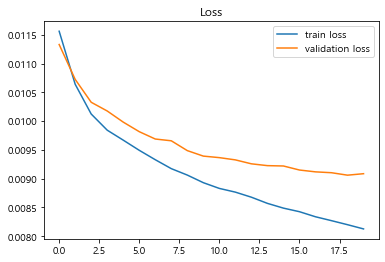

DNN learning curve 1/10


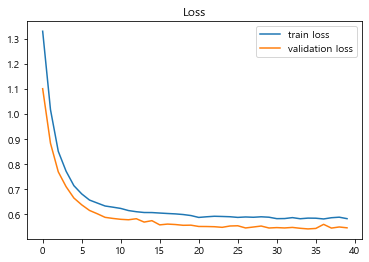

 10%|████████▎                                                                          | 1/10 [01:07<10:08, 67.65s/it]

AUC 0.7984586148648648
DAE learning curve 2/10


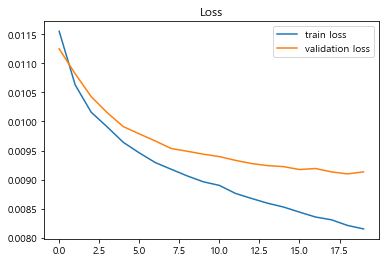

DNN learning curve 2/10


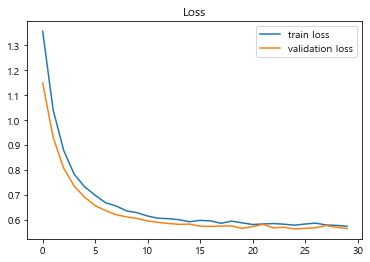

 20%|████████████████▌                                                                  | 2/10 [02:16<09:03, 67.97s/it]

AUC 0.7782044961119616
DAE learning curve 3/10


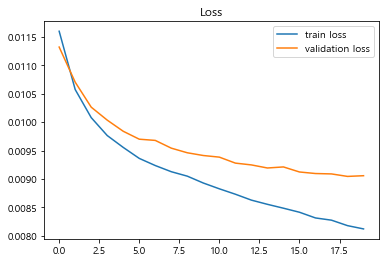

DNN learning curve 3/10


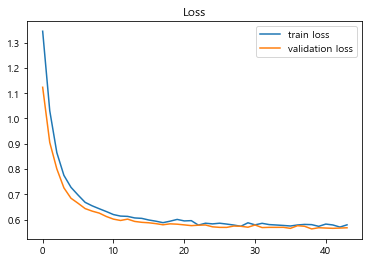

 30%|████████████████████████▉                                                          | 3/10 [03:24<07:57, 68.16s/it]

AUC 0.7719509219561504
DAE learning curve 4/10


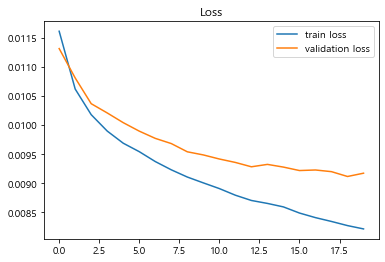

DNN learning curve 4/10


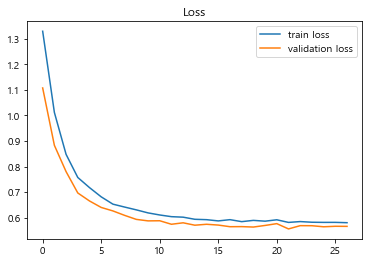

 40%|█████████████████████████████████▏                                                 | 4/10 [04:32<06:48, 68.09s/it]

AUC 0.7795208066248569
DAE learning curve 5/10


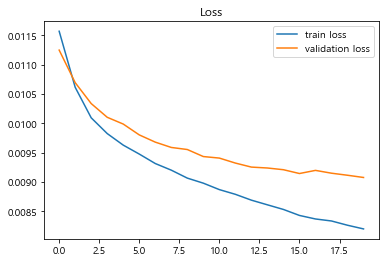

DNN learning curve 5/10


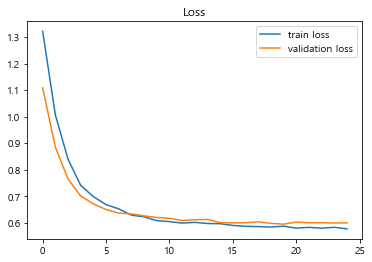

 50%|█████████████████████████████████████████▌                                         | 5/10 [05:39<05:38, 67.78s/it]

AUC 0.7212823194001304
DAE learning curve 6/10


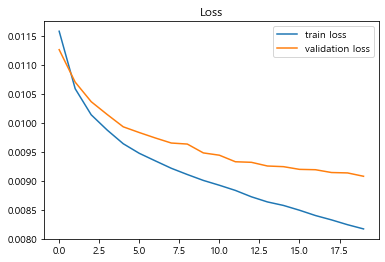

DNN learning curve 6/10


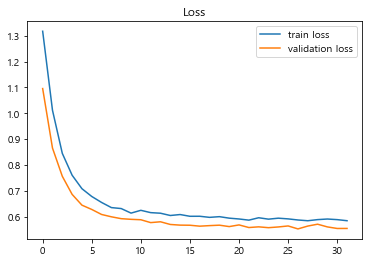

 60%|█████████████████████████████████████████████████▊                                 | 6/10 [06:48<04:31, 67.87s/it]

AUC 0.7577578134416227
DAE learning curve 7/10


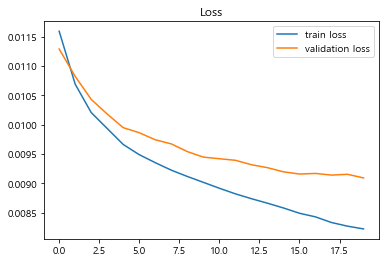

DNN learning curve 7/10


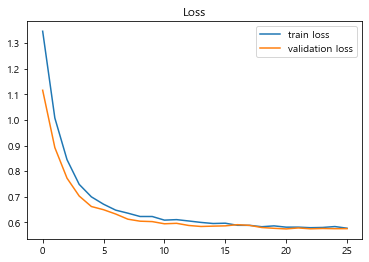

 70%|██████████████████████████████████████████████████████████                         | 7/10 [07:55<03:23, 67.79s/it]

AUC 0.7610380059359652
DAE learning curve 8/10


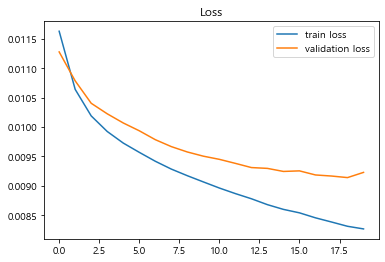

DNN learning curve 8/10


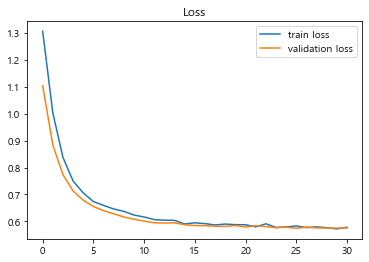

 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [09:03<02:15, 67.87s/it]

AUC 0.7619451855445064
DAE learning curve 9/10


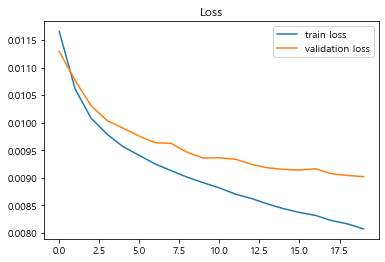

DNN learning curve 9/10


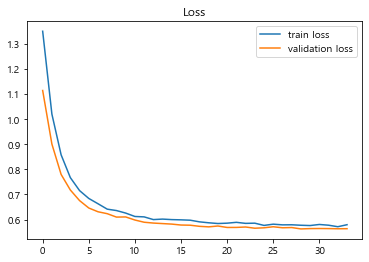

 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [10:12<01:08, 68.17s/it]

AUC 0.7698246714768728
DAE learning curve 10/10


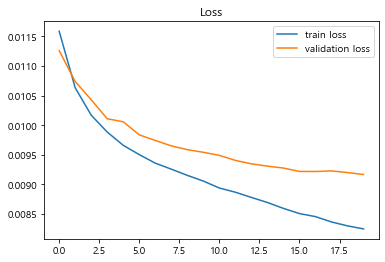

DNN learning curve 10/10


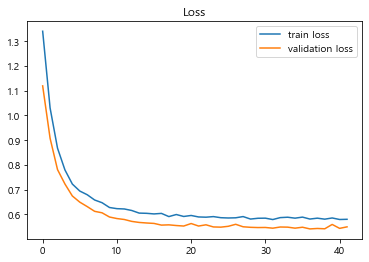

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [11:22<00:00, 68.28s/it]

AUC 0.7982744880634767

Validation Summary:
0    0.798459
9    0.798274
3    0.779521
1    0.778204
2    0.771951
8    0.769825
7    0.761945
6    0.761038
5    0.757758
4    0.721282
dtype: float64
mean=0.76983, std=0.022


In [15]:
# Set hyper-parameters for power mean ensemble 
N = 10
p = 3.5
preds = []
aucs = []

for i in tqdm(range(N)):    
    X_train, X_test = train, test

    ##### STEP 1: Randomize Seed
    SEED = np.random.randint(1, 10000)              
    random.seed(SEED)       
    np.random.seed(SEED)     
    if tf.__version__[0] < '2':  
        tf.set_random_seed(SEED)
    else:
        tf.random.set_seed(SEED)

    ##### STEP 2: Build DAE #####
    
    # Define the encoder dimension
    encoding_dim = 128

    # Input Layer
    input_dim = Input(shape = (X_train.shape[1], ))

    # Encoder Layers
    noise = Dropout(0.5)(input_dim) # for Denoising
    encoded1 = Dense(512, activation = 'relu')(noise)
    encoded2 = Dense(256, activation = 'relu')(encoded1)
    encoded3 = Dense(128, activation = 'relu')(encoded2)
    encoded4 = Dense(encoding_dim, activation = 'relu')(encoded3)

    # Decoder Layers
    decoded1 = Dense(128, activation = 'relu')(encoded4)
    decoded2 = Dense(256, activation = 'relu')(decoded1)
    decoded3 = Dense(512, activation = 'relu')(decoded2)
    decoded4 = Dense(X_train.shape[1], activation = 'linear')(decoded3)

    # Combine Encoder and Deocder layers
    autoencoder = Model(inputs = input_dim, outputs = decoded4)

    # Compile the model
    autoencoder.compile(optimizer = 'adam', loss = 'mse')

    # Train the model
    history = autoencoder.fit(X_train, X_train, epochs=20, batch_size=64, 
                              shuffle=True, validation_data=(X_test,X_test), verbose=0)

    print(f'DAE learning curve {i+1}/{N}')
    plt.plot(history.history["loss"], label="train loss")
    plt.plot(history.history["val_loss"], label="validation loss")
    plt.legend()
    plt.title("Loss")
    plt.show()

    ##### STEP 3: Reduce Dimension #####
        
    # Use a middle Bottleneck Layer to Reduce Dimension
    model = Model(inputs=input_dim, outputs=encoded4)
    X_train = model.predict(X_train)
    X_test = model.predict(X_test)

    ##### STEP 4: Build a DNN Model

    # Define the Model architecture
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    # Train the Model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    train_x, valid_x, train_y, valid_y = train_test_split(X_train, y_train, test_size=0.2)
    history = model.fit(train_x, train_y, epochs=100, batch_size=64, 
                        validation_data=(valid_x,valid_y), callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)], verbose=0)

    print(f'DNN learning curve {i+1}/{N}')
    plt.plot(history.history["loss"], label="train loss")
    plt.plot(history.history["val_loss"], label="validation loss")
    plt.legend()
    plt.title("Loss")
    plt.show()
    
    # Make Prediction
    auc = roc_auc_score(valid_y, model.predict(valid_x).flatten())
    aucs.append(auc)
    print('AUC', auc)
    preds.append(model.predict(X_test).flatten())   

### Validate the Models
print('\nValidation Summary:')
aucs = pd.Series(aucs)
print(aucs.sort_values(ascending=False))
print('mean={:.5f}, std={:.3f}'.format(aucs.mean(), aucs.std()))   

In [16]:
N = 10
p = [2.56, 3.5, 4.5]
for j in p:
    # Power mean ensemble
    THRESHOLD = 0.77  # Use only models whose AUC exceeds this value

    pred = 0
    n = 0
    for i in range(N):
        if aucs.iloc[i] > THRESHOLD:
            pred = pred + preds[i]**j
            n += 1
    pred = pred / n    
    pred = pred**(1/j)

    # Make a submission file
    t = pd.Timestamp.now()
    fname = f"dae_p{j}n{n}_submit_{t.month:02}{t.day:02}{t.hour:02}{t.minute:02}.csv"
    submissions = pd.concat([pd.Series(IDtest, name="cust_id"), pd.Series(pred, name="gender")] ,axis=1)
    submissions.to_csv(fname, index=False)
    print(f"'{fname}' is ready to submit.")

'dae_p2.56n5_submit_06121957.csv' is ready to submit.
'dae_p3.5n5_submit_06121957.csv' is ready to submit.
'dae_p4.5n5_submit_06121957.csv' is ready to submit.


In [17]:
ae_256 = pd.read_csv('dae_p2.56n5_submit_06121957.csv')
ae_35 = pd.read_csv('dae_p3.5n5_submit_06121957.csv')
ae_45 = pd.read_csv('dae_p4.5n5_submit_06121957.csv')

In [21]:
ae_45.isnull().any()

cust_id    False
gender     False
dtype: bool